# Introduction

In this notebook, we will learn how to create a reinforcmenet learning agent for self driving Mario Kart.
Then, we will build a leaderboard to compare the algrithms we build.

## Goals

The main goals of implementing self driving Mario Kart are:
- Understand the basics of Reinforcement Learning
- Get familiar with Open AI Gym and Universe
- Create an agent that is capable of learning by itself


# 1. Reinforcement Learning

## 1.1. Introduction
Those interested in the world of machine learning are aware of the capabilities of reinforcement-learning-based AI. The past few years have seen many breakthroughs using reinforcement learning (RL). The company DeepMind combined deep learning with reinforcement learning to achieve above-human results on a multitude of Atari games and, in March 2016, defeated Go champion Le Sedol four games to one. Though RL is currently excelling in many game environments, it is a novel way to solve problems that require optimal decisions and efficiency, and will surely play a part in machine intelligence to come.

Reinforcement learning, explained simply, is a computational approach where an agent interacts with an environment by taking actions in which it tries to maximize an accumulated reward. 
Here is a simple graph (the agent-environement loop), from the book [Reinforcement Learning: An Introduction 2nd Edition](http://incompleteideas.net/sutton/book/the-book-2nd.html) :

![RL](https://d3ansictanv2wj.cloudfront.net/image3-5f8cbb1fb6fb9132fef76b13b8687bfc.png)

An agent in a current state (St) takes an action (At) to which the environment reacts and responds, returning a new state(St+1) and reward (Rt+1) to the agent. Given the updated state and reward, the agent chooses the next action, and the loop repeats until an environment is solved or terminated.

Reinforcement learning provides the capacity for us not only to teach an artificial agent how to act, but to allow it to learn through it’s own interactions with an environment. By combining the complex representations that deep neural networks can learn with the goal-driven learning of an RL agent, computers have accomplished some amazing feats, like [beating humans at over a dozen Atari games](https://deepmind.com/dqn), and [defeating the Go world champion](https://deepmind.com/alpha-go).

Learning how to build these agents requires a bit of a change in thinking for anyone used to working in a supervised learning setting though. Gone is the ability to simply get the algorithm to pair certain stimuli with certain responses. Instead RL algorithms must enable the agent to learn the correct pairings itself through the use of observations, rewards, and actions. Since there is no longer a “True” correct action for an agent to take in any given circumstance that we can just tell it, things get a little tricky. In this post and those to follow, I will be walking through the creation and training of reinforcement learning agents. The agent and task will begin simple, so that the concepts are clear, and then work up to more complex task and environments.


## 1.2. OpenAI

OpenAI was founded in late 2015 as a non-profit with a mission to “build safe artificial general intelligence (AGI) and ensure AGI's benefits are as widely and evenly distributed as possible.” In addition to exploring many issues regarding AGI, one major contribution that OpenAI made to the machine learning world was developing both the Gym and Universe software platforms.

### OpenAI Gym
OpenAI Gym is a toolkit for developing and comparing reinforcement learning algorithms. It makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or Theano. You can use it from Python code, and soon from other languages.

OpenAI Gym consists of two parts:
- The gym open-source library: a collection of test problems — environments — that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.
- The OpenAI Gym service: a site and API allowing people to meaningfully compare performance of their trained agents.

### Running our first agent
Here's a bare minimum example of getting something running. This will run an instance of the CartPole-v0 environment for 1000 timesteps, rendering the environment at each step. You should see a window pop up rendering the classic cart-pole problem:

In [5]:
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action

[2018-06-04 07:20:04,862] Making new env: CartPole-v0
[2018-06-04 07:20:04,969] You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.


It should look something like this:

In [6]:
%%HTML
<video width="320" height="240" controls>
  <source src="./Videos/cartpole-no-reset.mp4" type="video/mp4">
</video>

If you'd like to see some other environments in action, try replacing CartPole-v0 above with something like MountainCar-v0, MsPacman-v0 (requires the Atari dependency), or Hopper-v1 (requires the MuJoCo dependencies). Environments all descend from the Env base class.

Note that if you're missing any dependencies, you should get a helpful error message telling you what you're missing.  Installing a missing dependency is generally pretty simple. You'll also need a MuJoCo license for Hopper-v1.

### Observtations

If we ever want to do better than take random actions at each step, it'd probably be good to actually know what our actions are doing to the environment.

The environment's step function returns exactly what we need. In fact, step returns four values. These are:

- observation (object): an environment-specific object representing your observation of the environment. For example, pixel data from a camera, joint angles and joint velocities of a robot, or the board state in a board game.
- reward (float): amount of reward achieved by the previous action. The scale varies between environments, but the goal is always to increase your total reward.
- done (boolean): whether it's time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, perhaps the pole tipped too far, or you lost your last life.)
- info (dict): diagnostic information useful for debugging. It can sometimes be useful for learning (for example, it might contain the raw probabilities behind the environment's last state change). However, official evaluations of your agent are not allowed to use this for learning.

This is just an implementation of the classic "agent-environment loop". Each timestep, the agent chooses an action, and the environment returns an observation and a reward.

![agent-environment loop](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

The process gets started by calling reset, which returns an initial observation. So a more proper way of writing the previous code would be to respect the done flag:

In [ ]:
import gym
env = gym.make('CartPole-v0')
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

## 1.3 Two-Armed Bandit

The simplest reinforcement learning problem is the n-armed bandit. Essentially, there are n-many slot machines, each with a different fixed payout probability. The goal is to discover the machine with the best payout, and maximize the returned reward by always choosing it. We are going to make it even simpler, by only having two possible slot machines to choose between. In fact, this problem is so simple that it is more of a precursor to real RL problems than one itself. 

Actually, typical aspects of a task that make it an RL problem are the following:

- Different actions yield different rewards. For example, when looking for treasure in a maze, going left may lead to the treasure, whereas going right may lead to a pit of snakes.
- Rewards are delayed over time. This just means that even if going left in the above example is the right thing to do, we may not know it till later in the maze.
- Reward for an action is conditional on the state of the environment. Continuing the maze example, going left may be ideal at a certain fork in the path, but not at others.

The n-armed bandit is a nice starting place because we don’t have to worry about aspects #2 and 3. All we need to focus on is learning which rewards we get for each of the possible actions, and ensuring we chose the optimal ones. 

In the context of RL lingo, this is called learning a policy. We are going to be using a method called policy gradients, where our simple neural network learns a policy for picking actions by adjusting its weights through gradient descent using feedback from the environment. 
There is another approach to reinforcement learning where agents learn value functions. In those approaches, instead of learning the optimal action in a given state, the agent learns to predict how good a given state or action will be for the agent to be in. Both approaches allow agents to learn good behavior, but the policy gradient approach is a little more direct.

## 1.4. Q-Learning and Exploration

Unlike policy gradient methods, which attempt to learn functions which directly map an observation to an action, Q-Learning attempts to learn the value of being in a given state, and taking a specific action there. While both approaches ultimately allow us to take intelligent actions given a situation, the means of getting to that action differ significantly.

For this tutorial we are going to be attempting to solve the [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0) environment from the OpenAI gym. For those unfamiliar, the [OpenAI gym](https://gym.openai.com/) provides an easy way for people to experiment with their learning agents in an array of provided toy games. The FrozenLake environment consists of a 4x4 grid of blocks, each one either being the start block, the goal block, a safe frozen block, or a dangerous hole. The objective is to have an agent learn to navigate from the start to the goal without moving onto a hole. At any given time the agent can choose to move either up, down, left, or right. The catch is that there is a wind which occasionally blows the agent onto a space they didn’t choose. As such, perfect performance every time is impossible, but learning to avoid the holes and reach the goal are certainly still doable. The reward at every step is 0, except for entering the goal, which provides a reward of 1. Thus, we will need an algorithm that learns long-term expected rewards. This is exactly what Q-Learning is designed to provide.

In it’s simplest implementation, Q-Learning is a table of values for every state (row) and action (column) possible in the environment. Within each cell of the table, we learn a value for how good it is to take a given action within a given state. In the case of the FrozenLake environment, we have 16 possible states (one for each block), and 4 possible actions (the four directions of movement), giving us a 16x4 table of Q-values. We start by initializing the table to be uniform (all zeros), and then as we observe the rewards we obtain for various actions, we update the table accordingly.

We make updates to our Q-table using something called the [Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation), which states that the expected long-term reward for a given action is equal to the immediate reward from the current action combined with the expected reward from the best future action taken at the following state. In this way, we reuse our own Q-table when estimating how to update our table for future actions! In equation form, the rule looks like this:

                Eq 1. Q(s,a) = r + γ(max(Q(s’,a’))
                
                
This says that the Q-value for a given state (s) and action (a) should represent the current reward (r) plus the maximum discounted (γ) future reward expected according to our own table for the next state (s’) we would end up in. The discount variable allows us to decide how important the possible future rewards are compared to the present reward. By updating in this way, the table slowly begins to obtain accurate measures of the expected future reward for a given action in a given state. Below is a Python walkthrough of the Q-Table algorithm implemented in the FrozenLake environment:


In [8]:
import gym
import numpy as np


# Load the environement
env = gym.make('FrozenLake-v0')

# Implement Q-Table Learning Algorithm
#Initialize table with all zeros
Q = np.zeros([env.observation_space.n,env.action_space.n])
# Set learning parameters
lr = .8
y = .95
num_episodes = 2000
#create lists to contain total rewards and steps per episode
#jList = []
rList = []
for i in range(num_episodes):
    #Reset environment and get first new observation
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    #The Q-Table learning algorithm
    while j < 99:
        j+=1
        #Choose an action by greedily (with noise) picking from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        #Get new state and reward from environment
        s1,r,d,_ = env.step(a)
        #Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll += r
        s = s1
        if d == True:
            break
    #jList.append(j)
    rList.append(rAll)

print "Score over time: " +  str(sum(rList)/num_episodes)
print "Final Q-Table Values"
print Q

[2018-06-04 07:21:27,642] Making new env: FrozenLake-v0


Score over time: 0.629
Final Q-Table Values
[[2.10799263e-01 1.01009378e-02 1.55837837e-02 1.41652064e-02]
 [1.78600526e-04 1.60928702e-04 5.93509283e-04 2.02593865e-01]
 [3.13566865e-03 1.48131656e-03 4.15535596e-03 1.44455912e-01]
 [8.02038186e-04 8.93375800e-04 6.68525405e-04 5.87832404e-02]
 [3.31181379e-01 2.33374391e-03 2.87647794e-03 2.71939045e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.09361623e-04 4.24355147e-03 1.68818058e-04 1.23796036e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.66111499e-03 1.82671705e-03 1.25873802e-03 2.32768410e-01]
 [0.00000000e+00 6.38280551e-01 3.35062847e-03 2.34232079e-03]
 [9.04579528e-01 7.95613892e-04 2.41367424e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.97112872e-01 0.00000000e+00]
 [0.00000000e+00 9.88841402e-01 0.00000000e+00 0.00000000e+00]
 [0.0000000

## 1.5. Q-Learning with Neural Networks

Now, you may be thinking: tables are great, but they don’t really scale, do they? While it is easy to have a 16x4 table for a simple grid world, the number of possible states in any modern game or real-world environment is nearly infinitely larger. For most interesting problems, tables simply don’t work. We instead need some way to take a description of our state, and produce Q-values for actions without a table: that is where neural networks come in. By acting as a function approximator, we can take any number of possible states that can be represented as a vector and learn to map them to Q-values.


In the case of the FrozenLake example, we will be using a one-layer network which takes the state encoded in a one-hot vector (1x16), and produces a vector of 4 Q-values, one for each action. Such a simple network acts kind of like a glorified table, with the network weights serving as the old cells. The key difference is that we can easily expand the Tensorflow network with added layers, activation functions, and different input types, whereas all that is impossible with a regular table. The method of updating is a little different as well. Instead of directly updating our table, with a network we will be using backpropagation and a loss function. Our loss function will be sum-of-squares loss, where the difference between the current predicted Q-values, and the “target” value is computed and the gradients passed through the network. In this case, our Q-target for the chosen action is the equivalent to the Q-value computed in equation 1 above.

            Eq2. Loss = ∑(Q-target - Q)²
            
Below is the Tensorflow walkthrough of implementing our simple Q-Network:

In [9]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Load the environement
env = gym.make('FrozenLake-v0')

# The Q-Network Approach
# Implementing the network itself

tf.reset_default_graph()
#These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

[2018-06-04 07:22:49,922] Making new env: FrozenLake-v0


In [10]:
# Training the network
init = tf.initialize_all_variables()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print "Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%"

[2018-06-04 07:23:02,653] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/util/tf_should_use.py:118: initialize_all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


Percent of succesful episodes: 0.337%


### Some statistics on network performance
We can see that the network beings to consistly reach the goal around the 750 episode mark.

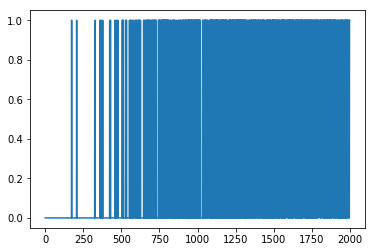

In [11]:
plt.plot(rList)

It also begins to progress through the environment for longer than chance aroudn the 750 mark as well.

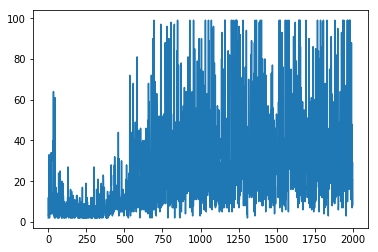

In [12]:
plt.plot(jList)

While the network learns to solve the FrozenLake problem, it turns out it doesn’t do so quite as efficiently as the Q-Table. While neural networks allow for greater flexibility, they do so at the cost of stability when it comes to Q-Learning. There are a number of possible extensions to our simple Q-Network which allow for greater performance and more robust learning. Two tricks in particular are referred to as Experience Replay and Freezing Target Networks. Those improvements and other tweaks were the key to getting Atari-playing Deep Q-Networks, and we will be exploring those additions in the future. For more info on the theory behind Q-Learning, see this great post by Tambet Matiisen. I hope this tutorial has been helpful for those curious about how to implement simple Q-Learning algorithms!

## 1.6. Policy Gradient

The simplest way to think of a Policy gradient network is one which produces explicit outputs. In the case of our bandit, we don’t need to condition these outputs on any state. As such, our network will consist of just a set of weights, with each corresponding to each of the possible arms to pull in the bandit, and will represent how good our agent thinks it is to pull each arm. If we initialize these weights to 1, then our agent will be somewhat optimistic about each arm’s potential reward.

To update our network, we will simply try an arm with an e-greedy policy (See Part 7 for more on action-selection strategies). This means that most of the time our agent will choose the action that corresponds to the largest expected value, but occasionally, with e probability, it will choose randomly. In this way, the agent can try out each of the different arms to continue to learn more about them. Once our agent has taken an action, it then receives a reward of either 1 or -1. With this reward, we can then make an update to our network using the policy loss equation:

                Loss = -log(π)*A

A is advantage, and is an essential aspect of all reinforcement learning algorithms. Intuitively it corresponds to how much better an action was than some baseline. In future algorithms, we will develop more complex baselines to compare our rewards to, but for now we will assume that the baseline is 0, and it can be thought of as simply the reward we received for each action.

π is the policy. In this case, it corresponds to the chosen action’s weight.

Intuitively, this loss function allows us to increase the weight for actions that yielded a positive reward, and decrease them for actions that yielded a negative reward. In this way the agent will be more or less likely to pick that action in the future. By taking actions, getting rewards, and updating our network in this circular manner, we will quickly converge to an agent that can solve our bandit problem! Don’t take my word for it though.

## Tutorial: The Multi-armed bandit

This tutorial contains a simple example of how to build a policy-gradient based agent that can solve the multi-armed bandit problem.

In [13]:
import tensorflow as tf
import numpy as np

### The Bandits

Here we define our bandits. For this example we are using a four-armed bandit. The pullBandit function generates a random number from a normal distribution with a mean of 0. The lower the bandit number, the more likely a positive reward will be returned. We want our agent to learn to always choose the bandit that will give that positive reward.


In [14]:
#List out our bandits. Currently bandit 4 (index#3) is set to most often provide a positive reward.
bandits = [0.2,0,-0.2,-5]
num_bandits = len(bandits)
def pullBandit(bandit):
    #Get a random number.
    result = np.random.randn(1)
    if result > bandit:
        #return a positive reward.
        return 1
    else:
        #return a negative reward.
        return -1

### The Agent
The code below established our simple neural agent. It consists of a set of values for each of the bandits. Each value is an estimate of the value of the return from choosing the bandit. We use a policy gradient method to update the agent by moving the value for the selected action toward the recieved reward.

In [15]:
tf.reset_default_graph()

#These two lines established the feed-forward part of the network. This does the actual choosing.
weights = tf.Variable(tf.ones([num_bandits]))
chosen_action = tf.argmax(weights,0)

#The next six lines establish the training proceedure. We feed the reward and chosen action into the network
#to compute the loss, and use it to update the network.
reward_holder = tf.placeholder(shape=[1],dtype=tf.float32)
action_holder = tf.placeholder(shape=[1],dtype=tf.int32)
responsible_weight = tf.slice(weights,action_holder,[1])
loss = -(tf.log(responsible_weight)*reward_holder)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
update = optimizer.minimize(loss)

### Training the Agent
We will train our agent by taking actions in our environment, and recieving rewards. Using the rewards and actions, we can know how to properly update our network in order to more often choose actions that will yield the highest rewards over time.

In [16]:
total_episodes = 1000 #Set total number of episodes to train agent on.
total_reward = np.zeros(num_bandits) #Set scoreboard for bandits to 0.
e = 0.1 #Set the chance of taking a random action.

init = tf.initialize_all_variables()

# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    i = 0
    while i < total_episodes:
        
        #Choose either a random action or one from our network.
        if np.random.rand(1) < e:
            action = np.random.randint(num_bandits)
        else:
            action = sess.run(chosen_action)
        
        reward = pullBandit(bandits[action]) #Get our reward from picking one of the bandits.
        
        #Update the network.
        _,resp,ww = sess.run([update,responsible_weight,weights], feed_dict={reward_holder:[reward],action_holder:[action]})
        
        #Update our running tally of scores.
        total_reward[action] += reward
        if i % 50 == 0:
            print "Running reward for the " + str(num_bandits) + " bandits: " + str(total_reward)
        i+=1
print "The agent thinks bandit " + str(np.argmax(ww)+1) + " is the most promising...."
if np.argmax(ww) == np.argmax(-np.array(bandits)):
    print "...and it was right!"
else:
    print "...and it was wrong!"

Running reward for the 4 bandits: [-1.  0.  0.  0.]
Running reward for the 4 bandits: [ 0. -1.  0. 46.]
Running reward for the 4 bandits: [ 0.  2.  0. 93.]
Running reward for the 4 bandits: [ -1.   2.   1. 139.]
Running reward for the 4 bandits: [ -2.   3.  -1. 183.]
Running reward for the 4 bandits: [ -3.   4.   1. 227.]
Running reward for the 4 bandits: [ -2.   4.   2. 275.]
Running reward for the 4 bandits: [ -1.   4.   2. 320.]
Running reward for the 4 bandits: [ -1.   4.   2. 370.]
Running reward for the 4 bandits: [ -2.   4.   5. 414.]
Running reward for the 4 bandits: [ -1.   4.   6. 462.]
Running reward for the 4 bandits: [ -2.   4.   6. 509.]
Running reward for the 4 bandits: [ -3.   5.   7. 554.]
Running reward for the 4 bandits: [ -3.   6.   7. 603.]
Running reward for the 4 bandits: [ -3.   7.   7. 650.]
Running reward for the 4 bandits: [ -4.   7.   7. 697.]
Running reward for the 4 bandits: [ -4.   6.   5. 744.]
Running reward for the 4 bandits: [ -4.   7.   6. 790.]
Runn

## 1.7. Policy-based Agents

Environments which pose the full problem to an agent are referred to as Markov Decision Processes (MDPs). These environments not only provide rewards and state transitions given actions, but those rewards are also condition on the state of the environment and the action the agent takes within that state. These dynamics are also temporal, and can be delayed over time.

To be a little more formal, we can define a Markov Decision Process as follows. An MDP consists of a set of all possible states S from which our agent at any time will experience s. A set of all possible actions A from which our agent at any time will take action a. Given a state action pair (s, a), the transition probability to a new state s’ is defined by T(s, a), and the reward r is given by R(s, a). As such, at any time in an MDP, an agent is given a state s, takes action a, and receives new state s’ and reward r.

While it may seem relatively simple, we can pose almost any task we could think of as an MDP. For example, imagine opening a door. The state is the vision of the door that we have, as well as the position of our body and door in the world. The actions are our every movement our body could make. The reward in this case is the door successfully opening. Certain actions, like walking toward the door are essential to solving the problem, but aren’t themselves reward-giving, since only actually opening the door will provide the reward. In this way, an agent needs to learn to assign value to actions the lead eventually to the reward, hence the introduction of temporal dynamics.



### Cart-Pole Task

In order to accomplish this, we are going to need a challenge that is more difficult for the agent than the two-armed bandit. To meet provide this challenge we are going to utilize the OpenAI gym, a collection of reinforcement learning environments. We will be using one of the classic tasks, the Cart-Pole. To learn more about the OpenAI gym, and this specific task, check out their tutorial [here](https://gym.openai.com/docs). Essentially, we are going to have our agent learn how to balance a pole for as long as possible without it falling. Unlike the two-armed bandit, this task requires:

- Observations — The agent needs to know where pole currently is, and the angle at which it is balancing. To accomplish this, our neural network will take an observation and use it when producing the probability of an action.

- Delayed reward — Keeping the pole in the air as long as possible means moving in ways that will be advantageous for both the present and the future. To accomplish this we will adjust the reward value for each observation-action pair using a function that weighs actions over time.

To take reward over time into account, the form of Policy Gradient we used in the previous tutorials will need a few adjustments. The first of which is that we now need to update our agent with more than one experience at a time. To accomplish this, we will collect experiences in a buffer, and then occasionally use them to update the agent all at once. These sequences of experience are sometimes referred to as rollouts, or experience traces. We can’t just apply these rollouts by themselves however, we will need to ensure that the rewards are properly adjusted by a discount factor

Intuitively this allows each action to be a little bit responsible for not only the immediate reward, but all the rewards that followed. We now use this modified reward as an estimation of the advantage in our loss equation. With those changes, we are ready to solve CartPole!

And with that we have a fully-functional reinforcement learning agent. Our agent is still far from the state of the art though. While we are using a neural network for the policy, the network still isn’t as deep or complex as the most advanced networks. In the next post I will be showing how to use Deep Neural Networks to create agents able to learn more complex relationships with the environment in order to play a more exciting game than pole balancing. In doing so, I will be diving into the kinds of representations that a network learns for more complex environments.

## 1.8. Model-Based RL

Now we will introduce the concept of a model of the environment that the agent can use to improve it’s performance.

What is a model and why would we want to use one? In this case, a model is going to be a neural network that attempts to learn the dynamics of the real environment. For example, in the CartPole we would like a model to be able to predict the next position of the Cart given the previous position and an action. By learning an accurate model, we can train our agent using the model rather than requiring to use the real environment every time. While this may seem less useful when the real environment is itself a simulation, like in our CartPole task, it can have huge advantages when attempting to learn policies for acting in the physical world.

Unlike in computer simulations, physical environments take time to navigate, and the physical rules of the world prevent things like easy environment resets from being feasible. Instead, we can save time and energy by building a model of the environment. With such a model, an agent can ‘imagine’ what it might be like to move around the real environment, and we can train a policy on this imagined environment in addition to the real one. If we were given a good enough model of an environment, an agent could be trained entirely on that model, and even perform well when placed into a real environment for the first time.

How are we going to accomplish this in Tensorflow? As I mentioned above, we are going to be using a neural network that will learn the transition dynamics between a previous observation and action, and the expected new observation, reward, and done state. Our training procedure will involve switching between training our model using the real environment, and training our agent’s policy using the model environment. By using this approach we will be able to learn a policy that allows our agent to solve the CartPole task without actually ever training the policy on the real environment! Read the iPython notebook below for the details on how this is done.

In this following part we implement a policy and model network which work in tandem to solve the CartPole reinforcement learning problem.

In [18]:
# Loading libraries and starting CartPole environment
import numpy as np
import cPickle as pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

# from modelAny import *

from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import embedding_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import rnn
# from tensorflow.python.ops import rnn_cell
from tensorflow.python.ops import variable_scope

In [19]:
import gym
env = gym.make('CartPole-v0')

[2018-06-04 07:29:23,679] Making new env: CartPole-v0


### Setting Hyper-parameters

In [20]:
# hyperparameters
H = 8 # number of hidden layer neurons
learning_rate = 1e-2
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?

model_bs = 3 # Batch size when learning from model
real_bs = 3 # Batch size when learning from real environment

# model initialization
D = 4 # input dimensionality

### Policy Network

In [21]:
tf.reset_default_graph()
observations = tf.placeholder(tf.float32, [None,4] , name="input_x")
W1 = tf.get_variable("W1", shape=[4, H],
           initializer=tf.contrib.layers.xavier_initializer())
layer1 = tf.nn.relu(tf.matmul(observations,W1))
W2 = tf.get_variable("W2", shape=[H, 1],
           initializer=tf.contrib.layers.xavier_initializer())
score = tf.matmul(layer1,W2)
probability = tf.nn.sigmoid(score)

tvars = tf.trainable_variables()
input_y = tf.placeholder(tf.float32,[None,1], name="input_y")
advantages = tf.placeholder(tf.float32,name="reward_signal")
adam = tf.train.AdamOptimizer(learning_rate=learning_rate)
W1Grad = tf.placeholder(tf.float32,name="batch_grad1")
W2Grad = tf.placeholder(tf.float32,name="batch_grad2")
batchGrad = [W1Grad,W2Grad]
loglik = tf.log(input_y*(input_y - probability) + (1 - input_y)*(input_y + probability))
loss = -tf.reduce_mean(loglik * advantages) 
newGrads = tf.gradients(loss,tvars)
updateGrads = adam.apply_gradients(zip(batchGrad,tvars))

[2018-06-04 07:29:30,491] From /usr/local/lib/python2.7/dist-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:198: retry (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Use the retry module or similar alternatives.


### Model Network
Here we implement a multi-layer neural network that predicts the next observation, reward, and done state from a current state and action.

In [22]:
mH = 256 # model layer size

input_data = tf.placeholder(tf.float32, [None, 5])
with tf.variable_scope('rnnlm'):
    softmax_w = tf.get_variable("softmax_w", [mH, 50])
    softmax_b = tf.get_variable("softmax_b", [50])

previous_state = tf.placeholder(tf.float32, [None,5] , name="previous_state")
W1M = tf.get_variable("W1M", shape=[5, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B1M = tf.Variable(tf.zeros([mH]),name="B1M")
layer1M = tf.nn.relu(tf.matmul(previous_state,W1M) + B1M)
W2M = tf.get_variable("W2M", shape=[mH, mH],
           initializer=tf.contrib.layers.xavier_initializer())
B2M = tf.Variable(tf.zeros([mH]),name="B2M")
layer2M = tf.nn.relu(tf.matmul(layer1M,W2M) + B2M)
wO = tf.get_variable("wO", shape=[mH, 4],
           initializer=tf.contrib.layers.xavier_initializer())
wR = tf.get_variable("wR", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())
wD = tf.get_variable("wD", shape=[mH, 1],
           initializer=tf.contrib.layers.xavier_initializer())

bO = tf.Variable(tf.zeros([4]),name="bO")
bR = tf.Variable(tf.zeros([1]),name="bR")
bD = tf.Variable(tf.ones([1]),name="bD")


predicted_observation = tf.matmul(layer2M,wO,name="predicted_observation") + bO
predicted_reward = tf.matmul(layer2M,wR,name="predicted_reward") + bR
predicted_done = tf.sigmoid(tf.matmul(layer2M,wD,name="predicted_done") + bD)

true_observation = tf.placeholder(tf.float32,[None,4],name="true_observation")
true_reward = tf.placeholder(tf.float32,[None,1],name="true_reward")
true_done = tf.placeholder(tf.float32,[None,1],name="true_done")

predicted_state = tf.concat([predicted_observation,predicted_reward,predicted_done],1)

observation_loss = tf.square(true_observation - predicted_observation)

reward_loss = tf.square(true_reward - predicted_reward)

done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1-predicted_done, 1-true_done)
done_loss = -tf.log(done_loss)


model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)

modelAdam = tf.train.AdamOptimizer(learning_rate=learning_rate)
updateModel = modelAdam.minimize(model_loss)

### Helper functions

In [23]:
def resetGradBuffer(gradBuffer):
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer
        
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r


# This function uses our model to produce a new state when given a previous state and action
def stepModel(sess, xs, action):
    toFeed = np.reshape(np.hstack([xs[-1][0],np.array(action)]),[1,5])
    myPredict = sess.run([predicted_state],feed_dict={previous_state: toFeed})
    reward = myPredict[0][:,4]
    observation = myPredict[0][:,0:4]
    observation[:,0] = np.clip(observation[:,0],-2.4,2.4)
    observation[:,2] = np.clip(observation[:,2],-0.4,0.4)
    doneP = np.clip(myPredict[0][:,5],0,1)
    if doneP > 0.1 or len(xs)>= 300:
        done = True
    else:
        done = False
    return observation, reward, done

### Training the Policy and Model

In [ ]:
xs,drs,ys,ds = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1
init = tf.initialize_all_variables()
batch_size = real_bs

drawFromModel = False # When set to True, will use model for observations
trainTheModel = True # Whether to train the model
trainThePolicy = False # Whether to train the policy
switch_point = 1

# Launch the graph
with tf.Session() as sess:
    rendering = False
    sess.run(init)
    observation = env.reset()
    x = observation
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 5000:
        # Start displaying environment once performance is acceptably high.
        if (reward_sum/batch_size > 150 and drawFromModel == False) or rendering == True : 
            env.render()
            rendering = True
            
        x = np.reshape(observation,[1,4])

        tfprob = sess.run(probability,feed_dict={observations: x})
        action = 1 if np.random.uniform() < tfprob else 0

        # record various intermediates (needed later for backprop)
        xs.append(x) 
        y = 1 if action == 0 else 0 
        ys.append(y)
        
        # step the  model or real environment and get new measurements
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess,xs,action)
                
        reward_sum += reward
        
        ds.append(done*1)
        drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

        if done: 
            
            if drawFromModel == False: 
                real_episodes += 1
            episode_number += 1

            # stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            xs,drs,ys,ds = [],[],[],[] # reset array memory
            
            if trainTheModel == True:
                actions = np.array([np.abs(y-1) for y in epy][:-1])
                state_prevs = epx[:-1,:]
                state_prevs = np.hstack([state_prevs,actions])
                state_nexts = epx[1:,:]
                rewards = np.array(epr[1:,:])
                dones = np.array(epd[1:,:])
                state_nextsAll = np.hstack([state_nexts,rewards,dones])

                feed_dict={previous_state: state_prevs, true_observation: state_nexts,true_done:dones,true_reward:rewards}
                loss,pState,_ = sess.run([model_loss,predicted_state,updateModel],feed_dict)
            if trainThePolicy == True:
                discounted_epr = discount_rewards(epr).astype('float32')
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr /= np.std(discounted_epr)
                tGrad = sess.run(newGrads,feed_dict={observations: epx, input_y: epy, advantages: discounted_epr})
                
                # If gradients becom too large, end training process
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                for ix,grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                
            if switch_point + batch_size == episode_number: 
                switch_point = episode_number
                if trainThePolicy == True:
                    sess.run(updateGrads,feed_dict={W1Grad: gradBuffer[0],W2Grad:gradBuffer[1]})
                    gradBuffer = resetGradBuffer(gradBuffer)

                running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
                if drawFromModel == False:
                    print 'World Perf: Episode %f. Reward %f. action: %f. mean reward %f.' % (real_episodes,reward_sum/real_bs,action, running_reward/real_bs)
                    if reward_sum/batch_size > 200:
                        break
                reward_sum = 0

                # Once the model has been trained on 100 episodes, we start alternating between training the policy
                # from the model and training the model from the real environment.
                if episode_number > 100:
                    drawFromModel = not drawFromModel
                    trainTheModel = not trainTheModel
                    trainThePolicy = not trainThePolicy
            
            if drawFromModel == True:
                observation = np.random.uniform(-0.1,0.1,[4]) # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
                
print real_episodes

### Checking model representation

Here we can examine how well the model is able to approximate the true environment after training. The green line indicates the real environment, and the blue indicates model predictions.

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


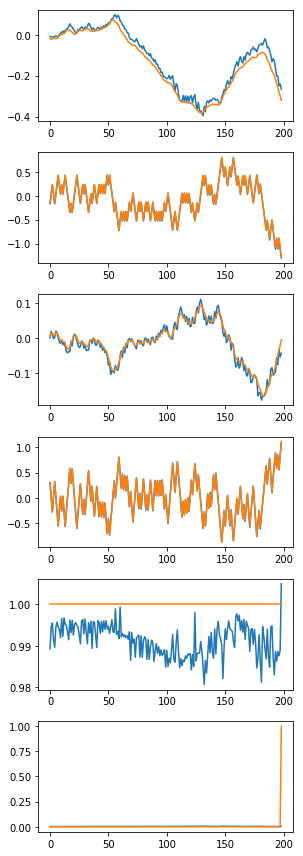

In [26]:
plt.figure(figsize=(8, 12))
for i in range(6):
    plt.subplot(6, 2, 2*i + 1)
    plt.plot(pState[:,i])
    plt.subplot(6,2,2*i+1)
    plt.plot(state_nextsAll[:,i])
plt.tight_layout()

Since there are now two network involved, there are plenty of hyper-parameters to adjust in order to improve performance or efficiency. I encourage you to play with them in order to discover better means of combining the the models. In Part 4 I will be exploring how to utilize convolutional networks to learn representations of more complex environments, such as Atari games.

## 1.9. Deep Q-Networks

In this tutorial we will be walking through the creation of a Deep Q-Network. It will be built upon the simple one layer Q-network we created in Part 0, so I would recommend reading that first if you are new to reinforcement learning. While our ordinary Q-network was able to barely perform as well as the Q-Table in a simple game environment, Deep Q-Networks are much more capable. In order to transform an ordinary Q-Network into a DQN we will be making the following improvements:

- Going from a single-layer network to a multi-layer convolutional network.
- Implementing Experience Replay, which will allow our network to train itself using stored memories from it’s experience.
- Utilizing a second “target” network, which we will use to compute target Q-values during our updates.

It was these three innovations that allowed the [Google DeepMind team to achieve superhuman performance on dozens of Atari games using their DQN agent](http://www.davidqiu.com:8888/research/nature14236.pdf). We will be walking through each individual improvement, and showing how to implement it. We won’t stop there though. The pace of Deep Learning research is extremely fast, and the DQN of 2014 is no longer the most advanced agent around anymore. I will discuss two simple additional improvements to the DQN architecture, Double DQN and Dueling DQN, that allow for improved performance, stability, and faster training time. In the end we will have a network that can tackle a number of challenging Atari games, and we will demonstrate how to train the DQN to learn a basic navigation task.

## Getting from Q-Network to Deep Q-Network
![DeepMind](https://cdn-images-1.medium.com/max/800/1*T54Ngd-b_CKcP3N6hyXLVg.png)

### Addition 1: Convolutional Layers
Since our agent is going to be learning to play video games, it has to be able to make sense of the game’s screen output in a way that is at least similar to how humans or other intelligent animals are able to. Instead of considering each pixel independently, convolutional layers allow us to consider regions of an image, and maintain spatial relationships between the objects on the screen as we send information up to higher levels of the network. In this way, they act similarly to human receptive fields. Indeed there is a body of research showing that convolutional neural network learn representations that are [similar to those of the primate visual cortex](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1003963). As such, they are ideal for the first few elements within our network.

In Tensorflow, we can utilize the tf.contrib.layers.convolution2d function to easily create a convolutional layer. We write for function as follows:

    convolution_layer = tf.contrib.layers.convolution2d(inputs,num_outputs,kernel_size,stride,padding)

Here num_outs refers to how many filters we would like to apply to the previous layer. kernel_size refers to how large a window we would like to slide over the previous layer. Stride refers to how many pixels we want to skip as we slide the window across the layer. Finally, padding refers to whether we want our window to slide over just the bottom layer (“VALID”) or add padding around it (“SAME”) in order to ensure that the convolutional layer has the same dimensions as the previous layer. For more information, see the [Tensorflow documentation](https://www.tensorflow.org/versions/r0.10/api_docs/python/contrib.layers.html#convolution2d).

### Addition 2: Experience Replay
The second major addition to make DQNs work is Experience Replay. The basic idea is that by storing an agent’s experiences, and then randomly drawing batches of them to train the network, we can more robustly learn to perform well in the task. By keeping the experiences we draw random, we prevent the network from only learning about what it is immediately doing in the environment, and allow it to learn from a more varied array of past experiences. Each of these experiences are stored as a tuple of <state,action,reward,next state>. The Experience Replay buffer stores a fixed number of recent memories, and as new ones come in, old ones are removed. When the time comes to train, we simply draw a uniform batch of random memories from the buffer, and train our network with them. For our DQN, we will build a simple class that handles storing and retrieving memories.

### Addition 3: Separate Target Network
The third major addition to the DQN that makes it unique is the utilization of a second network during the training procedure. This second network is used to generate the target-Q values that will be used to compute the loss for every action during training. Why not use just use one network for both estimations? The issue is that at every step of training, the Q-network’s values shift, and if we are using a constantly shifting set of values to adjust our network values, then the value estimations can easily spiral out of control. The network can become destabilized by falling into feedback loops between the target and estimated Q-values. In order to mitigate that risk, the target network’s weights are fixed, and only periodically or slowly updated to the primary Q-networks values. In this way training can proceed in a more stable manner.

Instead of updating the target network periodically and all at once, we will be updating it frequently, but slowly. This technique was introduced in another DeepMind paper earlier this year, where they found that it stabilized the training process.

### Going Beyond DQN
With the additions above, we have everything we need to replicate the DWN of 2014. But the world moves fast, and a number of improvements above and beyond the DQN architecture described by DeepMind, have allowed for even greater performance and stability. Before training your new DQN on your favorite ATARI game, I would suggest checking the newer additions out. I will provide a description and some code for two of them: Double DQN, and Dueling DQN. Both are simple to implement, and by combining both techniques, we can achieve better performance with faster training times.

### Double DQN
The main intuition behind Double DQN is that the regular DQN often overestimates the Q-values of the potential actions to take in a given state. While this would be fine if all actions were always overestimates equally, there was reason to believe this wasn’t the case. You can easily imagine that if certain suboptimal actions regularly were given higher Q-values than optimal actions, the agent would have a hard time ever learning the ideal policy. In order to correct for this, the authors of DDQN paper propose a simple trick: instead of taking the max over Q-values when computing the target-Q value for our training step, we use our primary network to chose an action, and our target network to generate the target Q-value for that action. By decoupling the action choice from the target Q-value generation, we are able to substantially reduce the overestimation, and train faster and more reliably. Below is the new DDQN equation for updating the target value.

        Q-Target = r + γQ(s’,argmax(Q(s’,a,ϴ),ϴ’))
        
### Dueling DQN
![Dueling DQN](https://cdn-images-1.medium.com/max/800/1*N_t9I7MeejAoWlDuH1i7cw.png)

In order to explain the reasoning behind the architecture changes that Dueling DQN makes, we need to first explain some a few additional reinforcement learning terms. The Q-values that we have been discussing so far correspond to how good it is to take a certain action given a certain state. This can be written as Q(s,a). This action given state can actually be decomposed into two more fundamental notions of value. The first is the value function V(s), which says simple how good it is to be in any given state. The second is the advantage function A(a), which tells how much better taking a certain action would be compared to the others. We can then think of Q as being the combination of V and A. More formally:

        Q(s,a) =V(s) + A(a)
        
The goal of Dueling DQN is to have a network that separately computes the advantage and value functions, and combines them back into a single Q-function only at the final layer. It may seem somewhat pointless to do this at first glance. Why decompose a function that we will just put back together? The key to realizing the benefit is to appreciate that our reinforcement learning agent may not need to care about both value and advantage at any given time. For example: imagine sitting outside in a park watching the sunset. It is beautiful, and highly rewarding to be sitting there. No action needs to be taken, and it doesn’t really make sense to think of the value of sitting there as being conditioned on anything beyond the environmental state you are in. We can achieve more robust estimates of state value by decoupling it from the necessity of being attached to specific actions.

### Putting it all together

![Env](https://cdn-images-1.medium.com/max/800/1*R2nBdO9nJJVY_z0MQO5UsQ.png)

Now that we have learned all the tricks to get the most out of our DQN, let’s actually try it on a game environment! While the DQN we have described above could learn ATARI games with enough training, getting the network to perform well on those games takes at least a day of training on a powerful machine. For educational purposes, I have built a simple game environment which our DQN learns to master in a couple hours on a moderately powerful machine (I am using a GTX970). In the environment the agent controls a blue square, and the goal is to navigate to the green squares (reward +1) while avoiding the red squares (reward -1). At the start of each episode all squares are randomly placed within a 5x5 grid-world. The agent has 50 steps to achieve as large a reward as possible. Because they are randomly positioned, the agent needs to do more than simply learn a fixed path, as was the case in the FrozenLake environment from Tutorial 0. Instead the agent must learn a notion of spatial relationships between the blocks. And indeed, it is able to do just that!

The game environment outputs 84x84x3 color images, and uses function calls as similar to the OpenAI gym as possible. In doing so, it should be easy to modify this code to work on any of the OpenAI atari games. I encourage those with the time and computing resources necessary to try getting the agent to perform well in an ATARI game. 

## Asynchronous Actor-Critic Agents (A3C)

In this section, we will provide a tutorial on implementing the Asynchronous Advantage Actor-Critic (A3C) algorithm in Tensorflow. We will use it to solve a simple challenge in a 3D Doom environment! With the holidays right around the corner, this will be my final post for the year, and I hope it will serve as a culmination of all the previous topics in the series. If you haven’t yet, or are new to Deep Learning and Reinforcement Learning, I suggest checking out the earlier entries in the series before going through this post in order to understand all the building blocks which will be utilized here. If you have been following the series: thank you! I have learned so much about RL in the past year, and am happy to have shared it with everyone through this article series.

So what is A3C? The [A3C algorithm](https://arxiv.org/pdf/1602.01783.pdf) was released by Google’s DeepMind group earlier this year, and it made a splash by… essentially obsoleting DQN. It was faster, simpler, more robust, and able to achieve much better scores on the standard battery of Deep RL tasks. On top of all that it could work in continuous as well as discrete action spaces. Given this, it has become the go-to Deep RL algorithm for new challenging problems with complex state and action spaces. In fact, OpenAI just released a version of A3C as their “universal starter agent” for working with their new (and very diverse) set of Universe environments.

### The 3 As of A3C

![Diagram of A3C high-level arcchitecture](https://cdn-images-1.medium.com/max/800/1*YtnGhtSAMnnHSL8PvS7t_w.png)

Asynchronous Advantage Actor-Critic is quite a mouthful. Let’s start by unpacking the name, and from there, begin to unpack the mechanics of the algorithm itself.

**Asynchronous**: Unlike DQN, where a single agent represented by a single neural network interacts with a single environment, A3C utilizes multiple incarnations of the above in order to learn more efficiently. In A3C there is a global network, and multiple worker agents which each have their own set of network parameters. Each of these agents interacts with it’s own copy of the environment at the same time as the other agents are interacting with their environments. The reason this works better than having a single agent (beyond the speedup of getting more work done), is that the experience of each agent is independent of the experience of the others. In this way the overall experience available for training becomes more diverse.

**Actor-Critic**: So far this series has focused on value-iteration methods such as Q-learning, or policy-iteration methods such as Policy Gradient. Actor-Critic combines the benefits of both approaches. In the case of A3C, our network will estimate both a value function V(s) (how good a certain state is to be in) and a policy π(s) (a set of action probability outputs). These will each be separate fully-connected layers sitting at the top of the network. Critically, the agent uses the value estimate (the critic) to update the policy (the actor) more intelligently than traditional policy gradient methods.

**Advantage**: If we think back to our implementation of Policy Gradient, the update rule used the discounted returns from a set of experiences in order to tell the agent which of its actions were “good” and which were “bad.” The network was then updated in order to encourage and discourage actions appropriately.

                    Discounted Reward: R = γ(r)

The insight of using advantage estimates rather than just discounted returns is to allow the agent to determine not just how good its actions were, but how much better they turned out to be than expected. Intuitively, this allows the algorithm to focus on where the network’s predictions were lacking. If you recall from the Dueling Q-Network architecture, the advantage function is as follow:

                    Advantage: A = Q(s,a) - V(s)

Since we won’t be determining the Q values directly in A3C, we can use the discounted returns (R) as an estimate of Q(s,a) to allow us to generate an estimate of the advantage.

                    Advantage Estimate: A = R - V(s)

In this tutorial, we will go even further, and utilize a slightly different version of advantage estimation with lower variance referred to as Generalized Advantage Estimation.

### Implementing the Algorithm
![workflow](https://cdn-images-1.medium.com/max/800/1*Hzql_1t0-wwDxiz0C97AcQ.png)



In the process of building this implementation of the A3C algorithm, I used as reference the quality implementations by [DennyBritz](https://github.com/dennybritz/reinforcement-learning) and [OpenAI](https://github.com/openai/universe-starter-agent). 

Both of which I highly recommend if you’d like to see alternatives to my code here. Each section embedded here is taken out of context for instructional purposes, and won’t run on its own. To view and run the full, functional A3C implementation, see this [Github repository](https://github.com/awjuliani/DeepRL-Agents/blob/master/A3C-Doom.ipynb).

The general outline of the code architecture is:

- **AC_Network** — This class contains all the Tensorflow ops to create the networks themselves.
- **Worker** — This class contains a copy of AC_Network, an environment class, as well as all the logic for interacting with the environment, and updating the global network.
- High-level code for establishing the Worker instances and running them in parallel.

The A3C algorithm begins by constructing the global network. This network will consist of convolutional layers to process spatial dependencies, followed by an LSTM layer to process temporal dependencies, and finally, value and policy output layers. Below is example code for establishing the network graph itself.

In [27]:
class AC_Network():
    def __init__(self,s_size,a_size,scope,trainer):
        with tf.variable_scope(scope):
            #Input and visual encoding layers
            self.inputs = tf.placeholder(shape=[None,s_size],dtype=tf.float32)
            self.imageIn = tf.reshape(self.inputs,shape=[-1,84,84,1])
            self.conv1 = slim.conv2d(activation_fn=tf.nn.elu,
                inputs=self.imageIn,num_outputs=16,
                kernel_size=[8,8],stride=[4,4],padding='VALID')
            self.conv2 = slim.conv2d(activation_fn=tf.nn.elu,
                inputs=self.conv1,num_outputs=32,
                kernel_size=[4,4],stride=[2,2],padding='VALID')
            hidden = slim.fully_connected(slim.flatten(self.conv2),256,activation_fn=tf.nn.elu)
            
            #Recurrent network for temporal dependencies
            lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(256,state_is_tuple=True)
            c_init = np.zeros((1, lstm_cell.state_size.c), np.float32)
            h_init = np.zeros((1, lstm_cell.state_size.h), np.float32)
            self.state_init = [c_init, h_init]
            c_in = tf.placeholder(tf.float32, [1, lstm_cell.state_size.c])
            h_in = tf.placeholder(tf.float32, [1, lstm_cell.state_size.h])
            self.state_in = (c_in, h_in)
            rnn_in = tf.expand_dims(hidden, [0])
            step_size = tf.shape(self.imageIn)[:1]
            state_in = tf.nn.rnn_cell.LSTMStateTuple(c_in, h_in)
            lstm_outputs, lstm_state = tf.nn.dynamic_rnn(
                lstm_cell, rnn_in, initial_state=state_in, sequence_length=step_size,
                time_major=False)
            lstm_c, lstm_h = lstm_state
            self.state_out = (lstm_c[:1, :], lstm_h[:1, :])
            rnn_out = tf.reshape(lstm_outputs, [-1, 256])
            
            #Output layers for policy and value estimations
            self.policy = slim.fully_connected(rnn_out,a_size,
                activation_fn=tf.nn.softmax,
                weights_initializer=normalized_columns_initializer(0.01),
                biases_initializer=None)
            self.value = slim.fully_connected(rnn_out,1,
                activation_fn=None,
                weights_initializer=normalized_columns_initializer(1.0),
                biases_initializer=None)

Next, a set of worker agents, each with their own network and environment are created. Each of these workers are run on a separate processor thread, so there should be no more workers than there are threads on your CPU.

In [ ]:
with tf.device("/cpu:0"): 
    master_network = AC_Network(s_size,a_size,'global',None) # Generate global network
    num_workers = multiprocessing.cpu_count() # Set workers ot number of available CPU threads
    workers = []
    # Create worker classes
    for i in range(num_workers):
        workers.append(Worker(DoomGame(),i,s_size,a_size,trainer,saver,model_path))

with tf.Session() as sess:
    coord = tf.train.Coordinator()
    if load_model == True:
        print 'Loading Model...'
        ckpt = tf.train.get_checkpoint_state(model_path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
        
    # This is where the asynchronous magic happens.
    # Start the "work" process for each worker in a separate threat.
    worker_threads = []
    for worker in workers:
        worker_work = lambda: worker.work(max_episode_length,gamma,master_network,sess,coord)
        t = threading.Thread(target=(worker_work))
        t.start()
        worker_threads.append(t)
    coord.join(worker_threads)

~ From here we go asynchronous ~

Each worker begins by setting its network parameters to those of the global network. We can do this by constructing a Tensorflow op which sets each variable in the local worker network to the equivalent variable value in the global network.

In [ ]:
# Copies one set of variables to another.
# Used to set worker network parameters to those of global network.
def update_target_graph(from_scope,to_scope):
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, to_scope)

    op_holder = []
    for from_var,to_var in zip(from_vars,to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder

class Worker():
    def __init__(self,game,name,s_size,a_size,trainer,saver,model_path):
        ....
        ....
        ....
        #Create the local copy of the network and the tensorflow op to copy global paramters to local network
        self.local_AC = AC_Network(s_size,a_size,self.name,trainer)
        self.update_local_ops = update_target_graph('global',self.name)        

Each worker then interacts with its own copy of the environment and collects experience. Each keeps a list of experience tuples (observation, action, reward, done, value) that is constantly added to from interactions with the environment.

In [ ]:
class Worker():
      ....
      ....
      ....
      def work(self,max_episode_length,gamma,global_AC,sess,coord):
        episode_count = 0
        total_step_count = 0
        print "Starting worker " + str(self.number)
        with sess.as_default(), sess.graph.as_default():                 
            while not coord.should_stop():
                sess.run(self.update_local_ops)
                episode_buffer = []
                episode_values = []
                episode_frames = []
                episode_reward = 0
                episode_step_count = 0
                d = False
                
                self.env.new_episode()
                s = self.env.get_state().screen_buffer
                episode_frames.append(s)
                s = process_frame(s)
                rnn_state = self.local_AC.state_init
                
                while self.env.is_episode_finished() == False:
                    #Take an action using probabilities from policy network output.
                    a_dist,v,rnn_state = sess.run([self.local_AC.policy,self.local_AC.value,self.local_AC.state_out], 
                        feed_dict={self.local_AC.inputs:[s],
                        self.local_AC.state_in[0]:rnn_state[0],
                        self.local_AC.state_in[1]:rnn_state[1]})
                    a = np.random.choice(a_dist[0],p=a_dist[0])
                    a = np.argmax(a_dist == a)

                    r = self.env.make_action(self.actions[a]) / 100.0
                    d = self.env.is_episode_finished()
                    if d == False:
                        s1 = self.env.get_state().screen_buffer
                        episode_frames.append(s1)
                        s1 = process_frame(s1)
                    else:
                        s1 = s
                        
                    episode_buffer.append([s,a,r,s1,d,v[0,0]])
                    episode_values.append(v[0,0])

                    episode_reward += r
                    s = s1                    
                    total_steps += 1
                    episode_step_count += 1
                    
                    #Specific to VizDoom. We sleep the game for a specific time.
                    if self.sleep_time>0:
                        sleep(self.sleep_time)
                    
                    # If the episode hasn't ended, but the experience buffer is full, then we
                    # make an update step using that experience rollout.
                    if len(episode_buffer) == 30 and d != True and episode_step_count != max_episode_length - 1:
                        # Since we don't know what the true final return is, we "bootstrap" from our current
                        # value estimation.
                        v1 = sess.run(self.local_AC.value, 
                            feed_dict={self.local_AC.inputs:[s],
                            self.local_AC.state_in[0]:rnn_state[0],
                            self.local_AC.state_in[1]:rnn_state[1]})[0,0]
                        v_l,p_l,e_l,g_n,v_n = self.train(global_AC,episode_buffer,sess,gamma,v1)
                        episode_buffer = []
                        sess.run(self.update_local_ops)
                    if d == True:
                        break
                                            
                self.episode_rewards.append(episode_reward)
                self.episode_lengths.append(episode_step_count)
                self.episode_mean_values.append(np.mean(episode_values))
                
                # Update the network using the experience buffer at the end of the episode.
                v_l,p_l,e_l,g_n,v_n = self.train(global_AC,episode_buffer,sess,gamma,0.0)

Once the worker’s experience history is large enough, we use it to determine discounted return and advantage, and use those to calculate value and policy losses. We also calculate an entropy (H) of the policy. This corresponds to the spread of action probabilities. If the policy outputs actions with relatively similar probabilities, then entropy will be high, but if the policy suggests a single action with a large probability then entropy will be low. We use the entropy as a means of improving exploration, by encouraging the model to be conservative regarding its sureness of the correct action.

                                        Value Loss: L = Σ(R - V(s))²
                                        Policy Loss: L = -log(π(s)) * A(s) - β*H(π)

A worker then uses these losses to obtain gradients with respect to its network parameters. Each of these gradients are typically clipped in order to prevent overly-large parameter updates which can destabilize the policy.

A worker then uses the gradients to update the global network parameters. In this way, the global network is constantly being updated by each of the agents, as they interact with their environment.

In [ ]:
class AC_Network():
    def __init__(self,s_size,a_size,scope,trainer):
        ....
        ....
        ....
        if scope != 'global':
            self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
            self.actions_onehot = tf.one_hot(self.actions,a_size,dtype=tf.float32)
            self.target_v = tf.placeholder(shape=[None],dtype=tf.float32)
            self.advantages = tf.placeholder(shape=[None],dtype=tf.float32)

            self.responsible_outputs = tf.reduce_sum(self.policy * self.actions_onehot, [1])

            #Loss functions
            self.value_loss = 0.5 * tf.reduce_sum(tf.square(self.target_v - tf.reshape(self.value,[-1])))
            self.entropy = - tf.reduce_sum(self.policy * tf.log(self.policy))
            self.policy_loss = -tf.reduce_sum(tf.log(self.responsible_outputs)*self.advantages)
            self.loss = 0.5 * self.value_loss + self.policy_loss - self.entropy * 0.01

            #Get gradients from local network using local losses
            local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope)
            self.gradients = tf.gradients(self.loss,local_vars)
            self.var_norms = tf.global_norm(local_vars)
            grads,self.grad_norms = tf.clip_by_global_norm(self.gradients,40.0)

            #Apply local gradients to global network
            global_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'global')
            self.apply_grads = trainer.apply_gradients(zip(grads,global_vars))

class Worker():
      ....
      ....
      ....
      def train(self,global_AC,rollout,sess,gamma,bootstrap_value):
        rollout = np.array(rollout)
        observations = rollout[:,0]
        actions = rollout[:,1]
        rewards = rollout[:,2]
        next_observations = rollout[:,3]
        values = rollout[:,5]

        # Here we take the rewards and values from the rollout, and use them to 
        # generate the advantage and discounted returns. 
        # The advantage function uses "Generalized Advantage Estimation"
        self.rewards_plus = np.asarray(rewards.tolist() + [bootstrap_value])
        discounted_rewards = discount(self.rewards_plus,gamma)[:-1]
        self.value_plus = np.asarray(values.tolist() + [bootstrap_value])
        advantages = rewards + gamma * self.value_plus[1:] - self.value_plus[:-1]
        advantages = discount(advantages,gamma)

        # Update the global network using gradients from loss
        # Generate network statistics to periodically save
        rnn_state = self.local_AC.state_init
        feed_dict = {self.local_AC.target_v:discounted_rewards,
            self.local_AC.inputs:np.vstack(observations),
            self.local_AC.actions:actions,
            self.local_AC.advantages:advantages,
            self.local_AC.state_in[0]:rnn_state[0],
            self.local_AC.state_in[1]:rnn_state[1]}
        v_l,p_l,e_l,g_n,v_n,_ = sess.run([self.local_AC.value_loss,
            self.local_AC.policy_loss,
            self.local_AC.entropy,
            self.local_AC.grad_norms,
            self.local_AC.var_norms,
            self.local_AC.apply_grads],
            feed_dict=feed_dict)
        return v_l / len(rollout),p_l / len(rollout),e_l / len(rollout), g_n,v_n

Once a successful update is made to the global network, the whole process repeats! The worker then resets its own network parameters to those of the global network, and the process begins again.

To view the full and functional code, see the Github repository [here](https://github.com/awjuliani/DeepRL-Agents/blob/master/A3C-Doom.ipynb).

### Playing Doom

![Doom](https://cdn-images-1.medium.com/max/800/1*yjPVxRywI8U9SKfCMCKR1A.png)


The robustness of A3C allows us to tackle a new generation of reinforcement learning challenges, one of which is 3D environments! We have come a long way from multi-armed bandits and grid-worlds, and in this tutorial, I have set up the code to allow for playing through the first VizDoom challenge. 

VizDoom is a system to allow for RL research using the classic Doom game engine. The maintainers of VizDoom recently created a pip package, so installing it is as simple as:

In [ ]:
pip install vizdoom

Once it is installed, we will be using the basic.wad environment, which is provided in the Github repository, and needs to be placed in the working directory.

The challenge consists of controlling an avatar from a first person perspective in a single square room. There is a single enemy on the opposite side of the room, which appears in a random location each episode. The agent can only move to the left or right, and fire a gun. The goal is to shoot the enemy as quickly as possible using as few bullets as possible. The agent has 300 time steps per episode to shoot the enemy. Shooting the enemy yields a reward of 1, and each time step as well as each shot yields a small penalty. After about 500 episodes per worker agent, the network learns a policy to quickly solve the challenge. Feel free to adjust parameters such as learning rate, clipping magnitude, update frequency, etc. to attempt to achieve ever greater performance or utilize A3C in your own RL tasks.

![Average reward over time for three workers on Doom task. 0.5 reward corresponds to optimal performance. X-axis represents number of training episodes per worker.](https://cdn-images-1.medium.com/max/800/1*DVaQXq6aVWYsU3S3INkV_w.png)

## MarioKart

The goal of this part is to apply Reinforcement Learning on Mario Kart. The first step deals with single player while the second focuses on using two models for two players.

### Single Player

#### Running the MarioKart Environement in OpenAI Gym
In this section, we will start configuring the OpenAI Gym environement for MarioKart.
The MarioKart enviroenment is not an official OpenAI Gym, it is an open source community project that can be found at https://github.com/bzier/gym-mupen64plus

![goal](https://cdn-images-1.medium.com/max/800/1*rb8r_CrUM8otagIb4ck_Tw.gif)

In [ ]:
import gym, gym_mupen64plus

env = gym.make('Mario-Kart-Luigi-Raceway-v0')
env.reset()
env.render()

for i in range(88):
    (obs, rew, end, info) = env.step([0, 0, 0, 0, 0]) # NOOP until green light
    env.render()

for i in range(100):
    (obs, rew, end, info) = env.step([0, 0, 1, 0, 0]) # Drive straight
    env.render()

raw_input("Press <enter> to exit... ")

env.close()

Now that you could launch a dummy mariokart for a single player, the idea would be to use A3C to initiate the learning process


# Agent Training

In the following examples, I use `mario-kart-agent` as the name of my project. You can use your own name instead, or you can remove the switch (`-p`) and project name and they will default to using the directory name.

## Start training:
After you've completed the build instructions above, starting training is as simple as:
```sh
docker-compose -p mario-kart-agent up -d
```

## Scaling workers:
If you have sufficient CPU, you can also spin up multiple worker containers that all communicate with the same parameter server container:
```sh
docker-compose -p mario-kart-agent up -d --scale worker=2
```
From the original A3C starter agent `README` page, the following recommendation was made. My CPU isn't good enough to even run more than one at a time, so I can't verify if this holds true for Mario Kart as well or not:
>For best performance, it is recommended for the number of workers to not exceed available number of CPU cores.

## Stop training:
When you are done, you can tear down the containers with:
```sh
docker-compose -p mario-kart-agent down
```

**`Note 1`**: This will destroy all of the containers, but not the underlying images that you previously built. You can just follow the instructions in [this section](#start-training) to start again.

**`Note 2`**: This will ***not*** destroy the `mklogs` volume, which is where all of the log data and model checkpoints are stored. This means that starting the containers again will pick up training essentially where it left off (not mid-episode, but with the parameters of the neural network where they were).

## Monitoring training:
### Tensorboard (i.e. training data)
Tensorboard is started in the parameter server container. This container has the Tensorboard port (`12345`) mapped to the same port on your host. In other words, you can browse to [`http://localhost:12345`](http://localhost:12345) to view the Tensorboard UI.

### VNC (i.e. watch the agent)
VNC is started in each worker container. Because workers can be scaled out, we can't map the container port to the host machine. Otherwise each of the containers would conflict fighting for the same host port. Instead, you can examine each worker container with:
```sh
docker inspect --format='{{range .NetworkSettings.Networks}}{{.IPAddress}}{{end}}::{{range $p, $conf := .NetworkSettings.Ports}}{{$p}} -> localhost::{{(index $conf 0).HostPort}}{{end}}' $INSTANCE_ID
```
*Here `$INSTANCE_ID` is the name or ID of the worker container you're interested in*

This will return something like:
```sh
172.17.0.2::5900/tcp -> localhost::32790
```
Then you can use your favorite VNC client to connect to localhost on the dynamically chosen port and watch the agent in real-time. Note that running the VNC client can cause some performance overhead.

### Multi player
Go through the code and update it so that it can now launch the game in multiplayer mode